## Initial Expansion to 5 Qubits

In [8]:
from qiskit import ClassicalRegister, generate_preset_pass_manager, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler

#### Declaration of backend

In [5]:
use_simulator = True

In [6]:
service = QiskitRuntimeService()
hardware = service.backend(name='ibm_rensselaer')
simulator = AerSimulator.from_backend(backend=hardware)

if use_simulator:
  backend = simulator
else:
  backend = hardware

#### Initialization of all the essential variables

In [7]:
t_start = 0
t_max = 3
dt = 0.1
shots = 8912
time_step_max = int(t_max/dt)
time_list = []
mags = []

#### Circuit for a single step

In [16]:
num_qubits = 5
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
circ = QuantumCircuit(qr, cr)
meas_circ = QuantumCircuit(qr, cr)
meas_circ.measure(qr, cr)

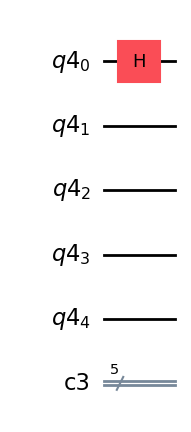

In [15]:
circ.h(qr[0])
circ.h(qr[1])
circ.sdg(qr[1])

circ.draw('mpl')

In [70]:
num_qubits = backend.num_qubits
omega = 1
dt = 0.1

circ = QuantumCircuit(num_qubits)

for i in range(num_qubits):
  circ.h(i)
  circ.sdg(i)

for i in range(num_qubits - 1):
  circ.cx(i, i + 1)

circ.rz(2 * omega * dt, num_qubits - 1)

for i in range(num_qubits - 1):
  circ.cx(num_qubits - (i + 2), num_qubits - (i + 1))

for i in range(num_qubits):
  circ.s(i)

# circ.draw()

In [56]:
circ.measure_active()

In [ ]:
circ.draw()

In [71]:
observables = []
for i in range(num_qubits):
  observable = "I" * i + "Z" + "I" * (num_qubits - i - 1)
  observables.append((observable, omega))
len(observables)


127

In [48]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(circ)
observable_corr = SparsePauliOp.from_list(observables)
isa_layout = observable_corr.apply_layout(isa_circuit.layout)

In [73]:
estimator = Estimator(mode=backend)
estimator.default_shots = 8192

In [52]:
sampler = Sampler(mode=backend)
sampler.default_shots = 8192

In [74]:
job = estimator.run([(isa_circuit, isa_layout)])
print(f"Job ID: {job.job_id()}")

Job ID: cwfa0m20r6b0008p9h60


In [78]:
job_finished = service.job('cwfa0m20r6b0008p9h60')
job_finished.status()

'DONE'

In [79]:
result = job_finished.result()

In [81]:
result[0].data.evs

array(4.37130895)